In [33]:
# generate the GWAS data for testing the variationl bayes methods
import numpy as np
import pandas as pd
from math import exp

# data shape
p = 300
true_p = 5
n = 300

maf = np.random.uniform(0.05, 0.5, p)
snps = np.empty(shape = (n, p))

for ind, f in np.ndenumerate(maf):
	snps[:, ind[0]] = np.random.binomial(2, f, n)

# normalize snps
snps = (snps - snps.mean(axis = 0)) / snps.std(axis = 0)

# generate genotypes
# select a subset to be in the true model
true_id = np.arange(1, true_p + 1)
true_snps = snps[:, true_id]
true_beta = np.random.normal(7, 2, len(true_id))
print(true_beta)

# create gene expression levels
def binomialize(x):
    p = 1 / (1 + exp(-x))
    return np.random.binomial(1, p, 1)
vbin = np.vectorize(binomialize)

true_snps = np.array(true_snps)
true_beta = np.array(true_beta)

geno = np.sum(true_snps * true_beta, axis = 1)
geno = vbin(geno)
print(geno)

geno = pd.DataFrame(geno)
snps = pd.DataFrame(snps)

# write the data in hdf5 format for faster reading
snps.to_hdf('data/snps.h5', 'data', mode='w', format='fixed')
geno.to_hdf('data/geno.h5', 'data', mode='w', format='fixed')

# save the true parameters
actual = pd.DataFrame({
	'snp_id': true_id
	,'beta': true_beta 
	})

actual.to_hdf('data/actual.h5', 'data', mode='w', format='fixed')


[ 8.16743668  9.29260905  7.68497844  8.5911935   5.20597175]
[1 0 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 0
 0 0 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 0
 1 1 0 0 0 0 0 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 0 0
 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 1 0 0 0
 1 1 0 0 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 1 1
 0 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 0 0 0 1 0 1 1 1 0 1
 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1
 0 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 1 0]


In [107]:
from pystan import StanModel

 # Begin Stan section
gwas_code = '''
data {
	// dimensions of the data
	int<lower = 0> N;
	int<lower = 0> P;

	// predictors (x) and target (y)
	matrix[N, P] x;
	int<lower = 0, upper = 1> y[N];
}

parameters {
	// regression coefficients
	vector[P] beta;

	// laplace parameters
	real<lower = 0> scale;
}

model {
	// instead use the laplace prior to regularize. Much easier convergence.
	//scale ~ gamma(2, 0.5);
	//scale ~ cauchy(0, 1);
	//scale ~ student_t(4, 0, 1);

	scale ~ gamma(2, 0.5);
	beta ~ double_exponential(0, scale);

	// construct model 
	y ~ bernoulli_logit(x * beta);
}
'''
model = StanModel(model_code = gwas_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_52fad90fc4153b783429d45816163e6c NOW.


In [27]:
from pystan import StanModel

 # Begin Stan section
gwas_code = '''
data {
	// dimensions of the data
	int<lower = 0> N;
	int<lower = 0> P;

	// predictors (x) and target (y)
	matrix[N, P] x;
	int<lower = 0, upper = 1> y[N];
}

parameters {
	// regression coefficients
	vector[P] beta;

	// horseshoe prior parameters
	vector<lower = 0>[P] lambda;
	vector<lower = 0>[P] eta;
    real<lower = 0> tau;
}

model {
	tau ~ cauchy(0, 1);
	eta ~ cauchy(0, 1);
	lambda ~ cauchy(0, tau * eta);
	beta ~ normal(0, lambda);

	// construct model 
	y ~ bernoulli_logit(x * beta);
}
'''
model = StanModel(model_code = gwas_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_734ab3219e792437d799af56926c0dfd NOW.


In [34]:
# read in previously generated data
geno = pd.read_hdf('data/geno.h5')
snps = pd.read_hdf('data/snps.h5')

geno = geno.values.flatten()
snps = snps.values

n = snps.shape[0]
p = snps.shape[1]

gwas_data = {
		'N': n
		,'P': p
		,'y': geno
		,'x': snps
	}

# HMC 
fit_hmc = model.sampling(data = gwas_data, n_jobs = -1)
print(fit_hmc)


Inference for Stan model: anon_model_734ab3219e792437d799af56926c0dfd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]    -2.2e-4  1.8e-3   0.02  -0.05-4.4e-3-3.9e-5 3.8e-3   0.05    160   1.02
beta[1]       9.01    0.82   2.72   5.45   7.25   8.38  10.21  17.72     11   1.48
beta[2]       8.86    0.87   2.89   4.96   7.02   8.23  10.03  18.17     11   1.51
beta[3]       8.04    0.82   2.58   4.55   6.37   7.54   9.15   16.1     10   1.59
beta[4]       9.62    0.94   3.11   5.75   7.54   8.85  10.92  19.43     11   1.48
beta[5]       5.56    0.52   1.71   3.29   4.39   5.19   6.35  10.92     11   1.48
beta[6]    -3.1e-3  4.7e-3   0.03  -0.11-4.9e-3-5.1e-5 3.5e-3   0.06     51   1.03
beta[7]    -9.9e-3    0.02   0.06  -0.24-6.4e-3 2.9e-5 7.1e-3   0.06     14   1.27
beta[8]      -0.03    0.03   0.16  -0.52-7.5e-3-1.9e-5 4.1e-3   

In [31]:
log_name = 'logs/hmc_beta_dist_as_N(7, 1)'
with open(log_name, "w") as f:
    f.write(str(fit_hmc))

In [29]:
# read in previously generated data
geno = pd.read_hdf('data/geno.h5')
snps = pd.read_hdf('data/snps.h5')

geno = geno.values.flatten()
snps = snps.values

n = snps.shape[0]
p = snps.shape[1]

gwas_data = {
		'N': n
		,'P': p
		,'y': geno
		,'x': snps
	}

# ADVI using stochastic gradient descent
fit_advi = model.vb(data = gwas_data
	,output_samples = 1000
	,iter = 40000
	,eval_elbo = 250
	,tol_rel_obj = 0.01
	,algorithm = 'meanfield')

# read in the posterior draws for each parameter
param_file = fit_advi['args']['sample_file'].decode("utf-8")
advi_coef = pd.read_csv(param_file, skiprows = [0, 1, 2, 3, 5, 6])

# relabel to have the actual indicies of the betas after the split
betas = advi_coef.filter(like = "beta")
betas.columns = ["beta." + str(j) for j in range(0, p)]

# save coefficients in hdf5 format
betas.to_hdf('data/betas.h5', 'data', mode='w', format='fixed')

# save other estimates in hdf5
param = advi_coef.filter(regex = "^(?!beta).*$")
param.to_hdf('data/param.h5', 'data', mode='w', format='fixed')

       beta  snp_id
0  7.678146       1
1  6.587088       2
2  7.132682       3
3  5.484338       4
4  7.992316       5


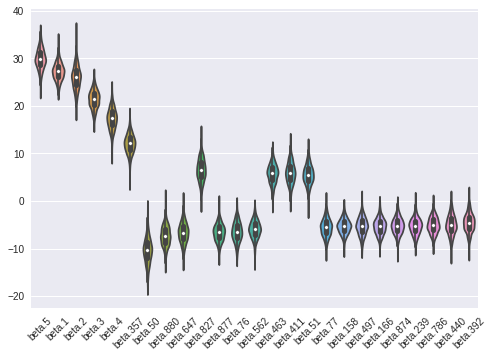

In [30]:
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats

raw_betas = pd.read_hdf('data/betas.h5')

n = raw_betas.shape[0]
p = raw_betas.shape[1]
true_p = 5

# print the actual values
actual = pd.read_hdf('data/actual.h5')
print(actual)

# print the actual values
# actual = pd.read_hdf('data/param.h5')

# unadjusted
betas = raw_betas.median(axis = 0)
top_betas = abs(betas).sort_values()[-25:][::-1]

beta_index = list(top_betas.index)
top_betas = raw_betas.filter(items = beta_index)

sb.violinplot(data = top_betas)
sb.plt.xticks(rotation = 45)
sb.plt.show()

# sb.regplot(actual.iloc[:, 0], betas[1:21])
# sb.plt.show()

